In [ ]:
# Author: Banafsheh Khazali and Shokoofa Ghods
# Date: March 06, 2023

## Libraries

In [2]:
!pip install git+https://github.com/lukemelas/EfficientNet-PyTorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lukemelas/EfficientNet-PyTorch to /tmp/pip-req-build-diiae0ys
  Running command git clone --filter=blob:none --quiet https://github.com/lukemelas/EfficientNet-PyTorch /tmp/pip-req-build-diiae0ys
  Resolved https://github.com/lukemelas/EfficientNet-PyTorch to commit 7e8b0d312162f335785fb5dcfa1df29a75a1783a
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=20624 sha256=02364fe1f2a75ccda4c362af865f5654e999cb17094933cdf0070c578ee5b0a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-_tnzbsco/wheels/ba/99/e4/bb3bbe6464a22b50da4bf9be868ba4501ac117142a2cdb30fc
Successfully built efficientnet-pytorch


In [3]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image
from datetime import datetime

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import random_split
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip -q "/content/drive/MyDrive/data/Dataset.zip" -d "data"

In [5]:
data = pd.read_csv('/content/drive/MyDrive/train.csv')
data
np_data = data.values

## Load all data in a numpy array

In [6]:
filename = '/content/drive/MyDrive/train/'
X = np.empty(shape=(4135,224,224,3), dtype= np.uint8)
for i in range(4135):
  image = Image.open(filename + np_data[i][0]).resize((224,224))
  img = np.array(image)
  X[i] = np.array(image)
 

# Define Transformers

In [7]:
from torchvision.transforms import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-30, 30))], p = 0.2),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.3),
    transforms.RandomGrayscale(0.2),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2))], p=0.2),
])

    


# Map images to their labels

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.data = data
        self.transform = transform
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        image = self.x[index]
        label = self.y[index]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        
        # Return the image and label as tensors
        return image, label

    def number_of_classes(self):
      return self.y.max() + 1

In [9]:
def visualization(image, label=0):
  plt.figure(figsize= (10,8))
  plt.imshow(image.permute(1,2,0))
  plt.xticks([])
  plt.yticks([])
  plt.show()

# Load the train dataset from the folder

In [10]:
train_dataset = CustomDataset(X,np_data[:,1] , transform=train_transform)

# Split the data into train and validation sets 

In [11]:
train_data, val_data = random_split(train_dataset, [0.8, 0.2])

## Visualize one sample

torch.Size([3, 224, 224])


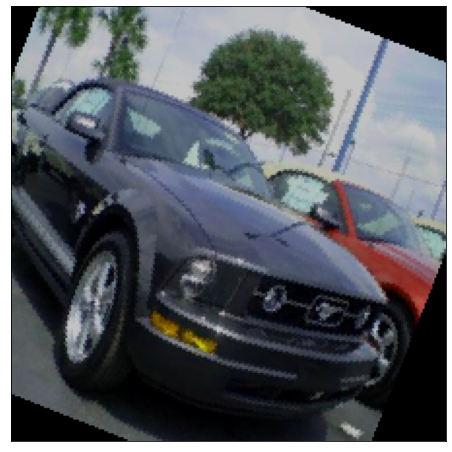

In [12]:
img, label = train_dataset[106]
print(img.shape)
visualization(img)

# Create data loaders for the train and validation sets



In [13]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
    
)

# Using EfficientNet

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load EfficientNet model with pretrained weights
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace last fully connected layer with a new one
num_ftrs = model._fc.in_features
model._fc = torch.nn.Linear(num_ftrs, train_dataset.number_of_classes())

model.to(device)

cpu


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

# Define loss and optimizer

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(device)

cpu


# Train the model

In [16]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch+1}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')



In [ ]:
# model = model.to(device)
epochs = 30
for epoch in range(epochs):
  model.train()
  total = 0
  total_correct = 0
  total_loss = 0
  total_l = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total += images.size(0)
    _, predictions = outputs.max(1)
    total_correct += (predictions == labels).sum()
    total_loss += loss.item() * images.size(0)
  accuracy = total_correct / total
  loss = total_loss / total
  print(f'Train epoch {epoch+1}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')
  evaluate(model, val_loader, device, criterion, mode='valid')
  print('---------')
  torch.save(model.state_dict(), f'model_v4_{epoch}.pt')


In [ ]:
  torch.save(model.state_dict(), 'model_v2.pt')
